In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=150,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3
import sys
sys.path.append("/home/qukun/xuhao/workspace/Utils")
import sc_plot
from sc_process import grouped_obs_mean
from sc_plot import plot_proportion

In [3]:
cx_fibro = sc.read_h5ad('../scripts/CX_20211030/s08_cx_fibro.h5ad')

In [4]:
sc.pp.neighbors(cx_fibro,use_rep='X_harmony')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)


In [5]:
sc.tl.umap(cx_fibro)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [4]:
cx_fibro.obs[['umap_1','umap_2']] = cx_fibro.obsm['X_umap']

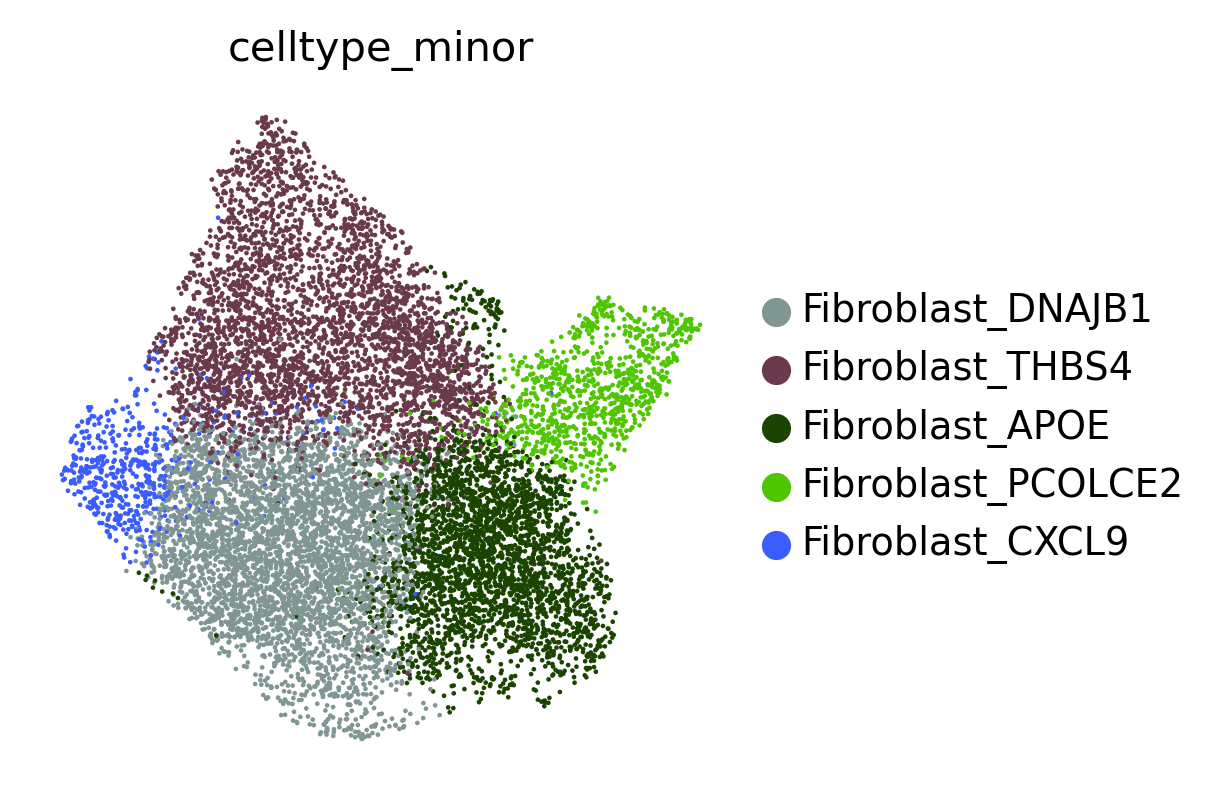

In [6]:
sc.pl.umap(cx_fibro, color='celltype_minor',frameon=False,size=5)

In [17]:
cx_fibro.layers['scaled'] = sc.pp.scale(cx_fibro,max_value=10,copy=True).X

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [19]:
sc.tl.rank_genes_groups(cx_fibro,groupby='celltype_minor',key_added='celltype_minor_degs',method='wilcoxon',use_raw=False,pts=True)

ranking genes


... storing 'cli_celltype_minor' as categorical


    finished: added to `.uns['celltype_minor_degs']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


In [20]:
def get_all_cluster_degs(ad,cluster_key,degs_key,log2fc_min=0.5,pval_cutoff=0.01,pts_min=0.1,n_top=None):
    df_list = []
    if type(ad.obs[cluster_key]) == pd.core.series.Series:
        cluster_order = ad.obs[cluster_key].cat.categories
    else:
        cluster_order = np.unique(ad.obs[cluster_key])
    for c in cluster_order:
        df = sc.get.rank_genes_groups_df(ad,group=c,key=degs_key,log2fc_min=log2fc_min,pval_cutoff=pval_cutoff)
        df = df[df['pct_nz_group'] > pts_min]
        df['cluster'] = c
        if n_top is not None:
            df = df.iloc[:n_top,:]
        df_list.append(df)
    df_all = pd.concat(df_list,axis=0)
    df_all = df_all.reset_index(drop=True)
    return df_all

In [21]:
cx_fibro_all_degs = get_all_cluster_degs(cx_fibro,'celltype_minor','celltype_minor_degs',n_top=5)

In [22]:
cx_fibro_all_degs_dict = {}
for c in cx_fibro_all_degs['cluster'].unique():
    cx_fibro_all_degs_dict[c] = list(cx_fibro_all_degs[cx_fibro_all_degs['cluster'] == c]['names'].values)

In [24]:
cx_fibro.obs[['umap_1','umap_2','celltype_minor','cli_state','lr_up_ligand','lr_down_ligand','inflam_res_score','ecm_score']]

,umap_1,umap_2,celltype_minor,cli_state,lr_up_ligand,lr_down_ligand,inflam_res_score,ecm_score
TTCGATTTCATACAGC-1_1,-8.766373,-6.831995,Fibroblast_DNAJB1,SjS,0.303976,0.419016,0.044474,0.247623
TTTATGCGTCGTATTG-1_1,-7.343091,-6.747490,Fibroblast_APOE,SjS,0.773259,0.321979,0.064434,0.196554
CTTACCGCAACCAACT-1_1,-7.890909,-3.347589,Fibroblast_APOE,SjS,-0.111510,0.352292,0.008168,0.157981
GATCACACAGTCGGTC-1_1,-7.777191,-4.162181,Fibroblast_APOE,SjS,0.278248,0.796899,0.007643,0.210831
CAATCGATCACTTTGT-1_2,-10.248794,-4.263390,Fibroblast_THBS4,SjS,0.662022,0.315187,0.081155,0.187065
...,...,...,...,...,...,...,...,...
CATTGTTGTCTACATG-1_16,-7.760804,-4.674771,Fibroblast_APOE,HC,0.156200,0.578790,0.033717,0.196087
ACCGTTCGTTGCTCAA-1_16,-7.352000,-6.088380,Fibroblast_APOE,HC,0.117415,0.288267,0.033890,0.156976
AGTTAGCCAAGTCCAT-1_16,-7.974365,-6.141726,Fibroblast_APOE,HC,0.214862,0.423555,0.023724,0.163802
CTGTAGACATCGGCCA-1_16,-7.767591,-5.225691,Fibroblast_APOE,HC,0.064849,0.548093,0.040425,0.168426


In [31]:
cx_fibro.to_df().loc[:,cx_fibro_all_degs_dict['Fibroblast_DNAJB1']+cx_fibro_all_degs_dict['Fibroblast_THBS4']+cx_fibro_all_degs_dict['Fibroblast_APOE']+cx_fibro_all_degs_dict['Fibroblast_PCOLCE2']+cx_fibro_all_degs_dict['Fibroblast_CXCL9']+up_genes.tolist()+down_genes.tolist()].to_csv('source_data_fig5e&sfig8.to_csv')

['HSP90AB1',
 'DNAJB1',
 'NFKBIA',
 'EIF1',
 'JUN',
 'SPON2',
 'F2R',
 'THBS4',
 'PTN',
 'SERPINE2',
 'MT-CYB',
 'MT-ND3',
 'MT-ND1',
 'MT-ND4',
 'MT-ND2',
 'MFAP5',
 'DCN',
 'CLEC3B',
 'TNXB',
 'S100A10',
 'IL32',
 'RBP5',
 'CD74',
 'B2M',
 'CTSH',
 'ADM',
 'C3',
 'CCL19',
 'CCL2',
 'CXCL1',
 'CXCL10',
 'CXCL12',
 'CXCL2',
 'CXCL3',
 'CXCL9',
 'GAS6',
 'HLA-A',
 'HLA-B',
 'HLA-C',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1',
 'HLA-DQA1',
 'HLA-DQB1',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-F',
 'IL6',
 'MDK',
 'MIF',
 'COL1A1',
 'COL1A2',
 'COL4A1',
 'COL4A2',
 'COL6A1',
 'COL6A2',
 'COL6A3',
 'FN1',
 'HSPG2',
 'INHBA',
 'LAMA2',
 'LAMB1',
 'RELN',
 'SEMA4A',
 'SEMA5A',
 'TAC1',
 'THBS4',
 'THY1']

In [29]:
up_genes.tolist()+down_genes.tolist()

['ADM',
 'C3',
 'CCL19',
 'CCL2',
 'CXCL1',
 'CXCL10',
 'CXCL12',
 'CXCL2',
 'CXCL3',
 'CXCL9',
 'GAS6',
 'HLA-A',
 'HLA-B',
 'HLA-C',
 'HLA-DMA',
 'HLA-DPA1',
 'HLA-DPB1',
 'HLA-DQA1',
 'HLA-DQB1',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-F',
 'IL6',
 'MDK',
 'MIF',
 'COL1A1',
 'COL1A2',
 'COL4A1',
 'COL4A2',
 'COL6A1',
 'COL6A2',
 'COL6A3',
 'FN1',
 'HSPG2',
 'INHBA',
 'LAMA2',
 'LAMB1',
 'RELN',
 'SEMA4A',
 'SEMA5A',
 'TAC1',
 'THBS4',
 'THY1']

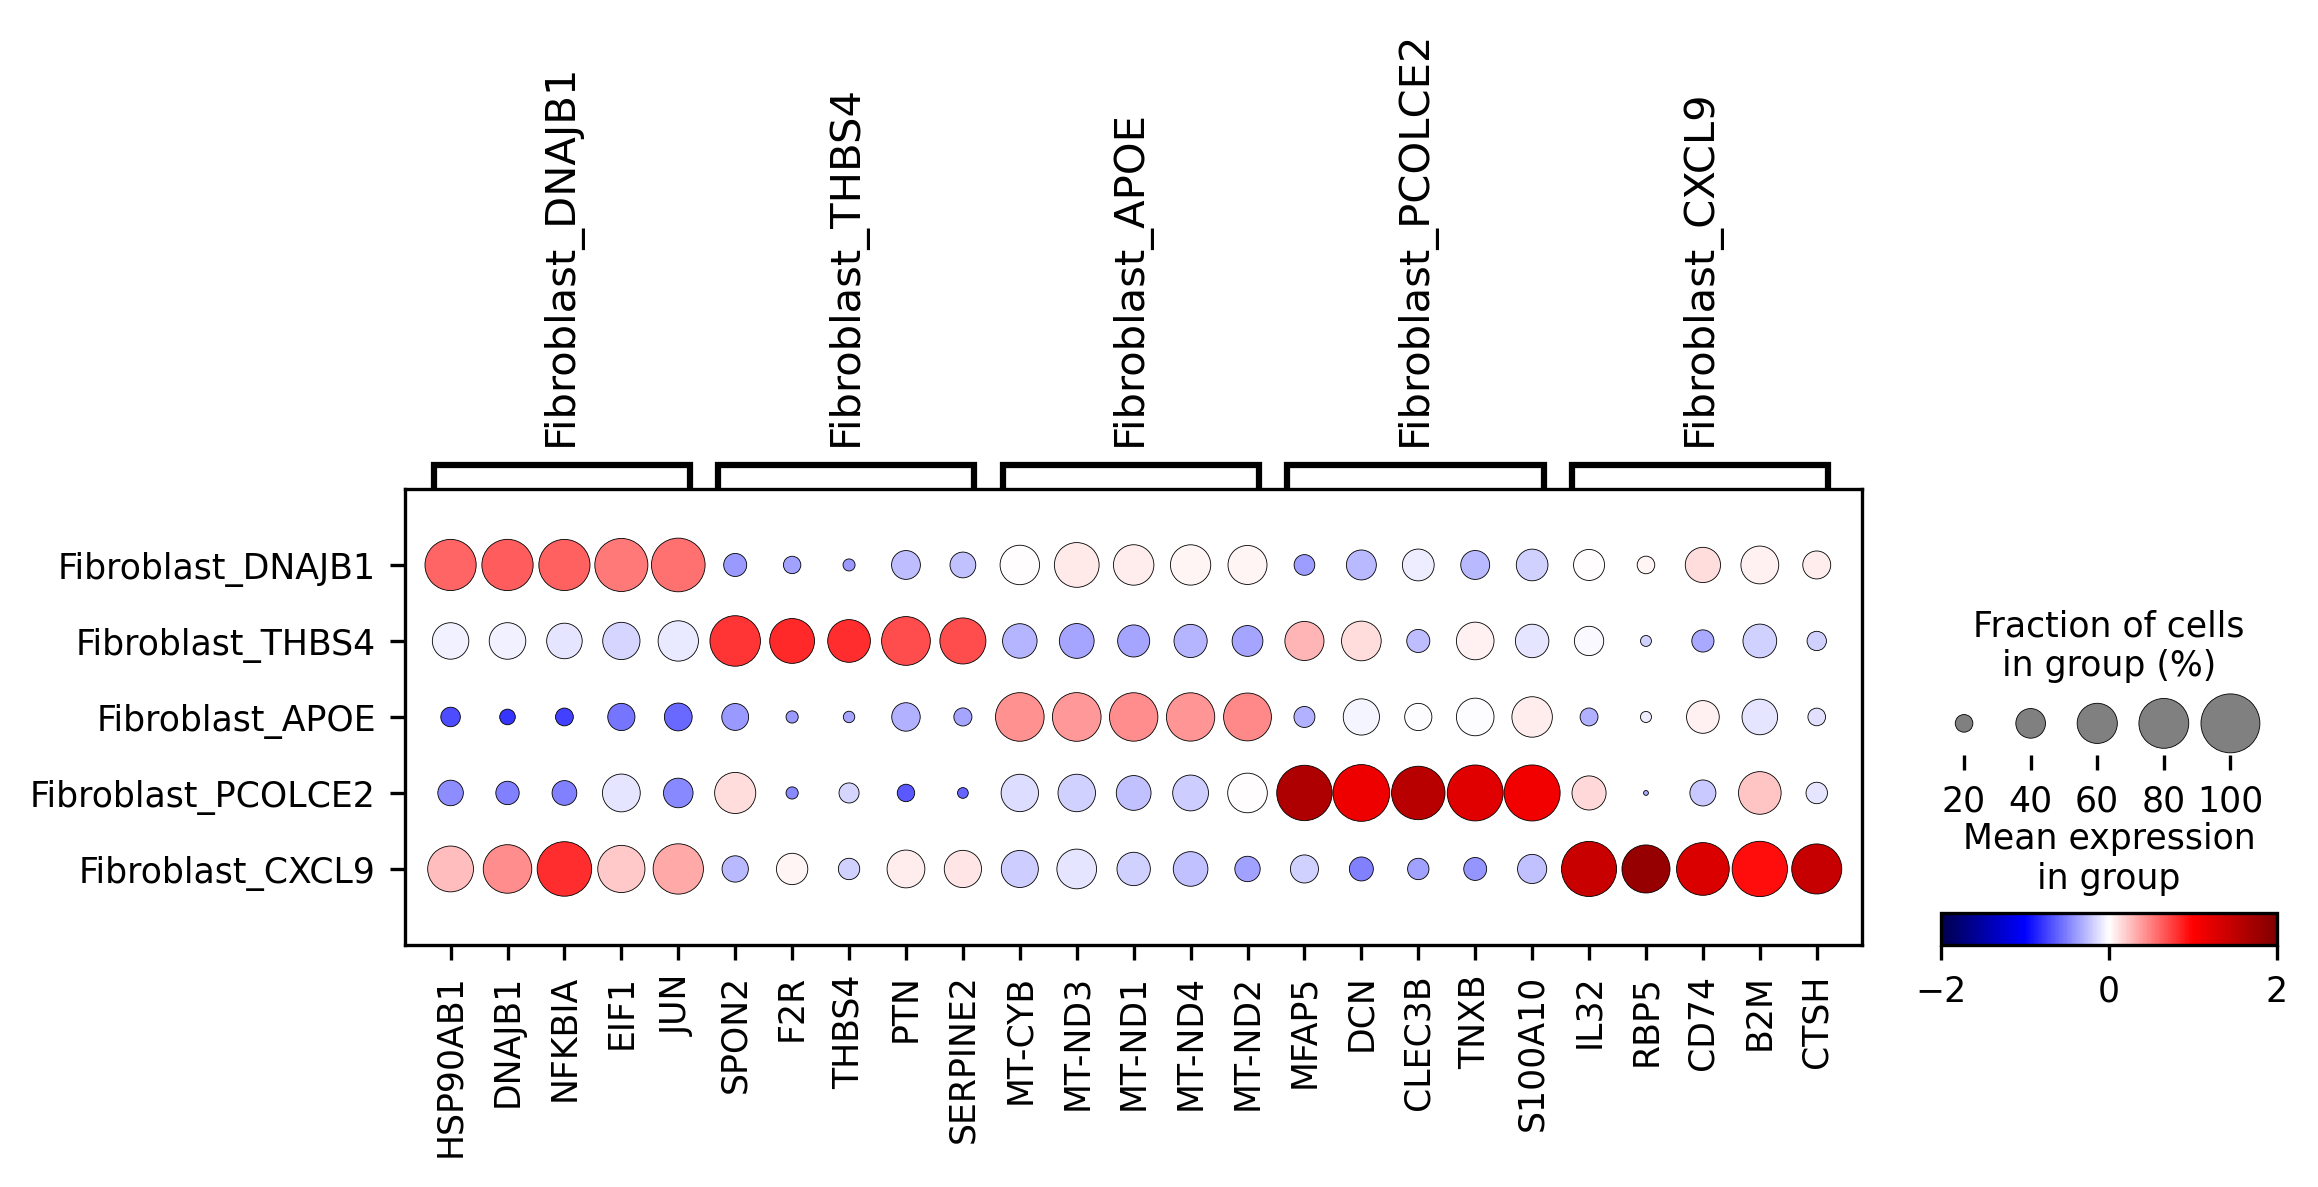

In [26]:
sc.pl.dotplot(cx_fibro, cx_fibro_all_degs_dict,groupby='celltype_minor',layer='scaled',use_raw=False,cmap='seismic',vmax=2,vmin=-2,figsize=(8,2),save='_cx_fibro_celltype_minor_degs_top5.pdf')


In [8]:
cx_fibro_cli_state_df_list = []
for c in cx_fibro.obs.celltype_minor.unique():
    cx_fibro_ctmp = cx_fibro[cx_fibro.obs.celltype_minor==c].copy()
    sc.tl.rank_genes_groups(cx_fibro_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
    cx_fibro_ctmp_df = sc.get.rank_genes_groups_df(cx_fibro_ctmp,group='SjS',key=f'{c}_cli')
#     cx_fibro_ctmp_df = cx_fibro_ctmp_df[(cx_fibro_ctmp_df['logfoldchanges'] > 0.5) | (cx_fibro_ctmp_df['logfoldchanges'] < -0.5)]
    # cx_fibro_ctmp_df = cx_fibro_ctmp_df[cx_fibro_ctmp_df['pct_nz_group'] > 0.1]
    cx_fibro_ctmp_df['celltype_minor'] = c
    cx_fibro_cli_state_df_list.append(cx_fibro_ctmp_df)

ranking genes
    finished: added to `.uns['Fibroblast_DNAJB1_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)
ranking genes
    finished: added to `.uns['Fibroblast_APOE_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes
    finished: added to `.uns['Fibroblast_THBS4_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarra

In [9]:
cx_fibro_cli_state_df_all = pd.concat(cx_fibro_cli_state_df_list,axis=0)

In [10]:
cx_fibro_cli_state_df = cx_fibro_cli_state_df_all[(np.abs(cx_fibro_cli_state_df_all.logfoldchanges) > 0.5)&(cx_fibro_cli_state_df_all.pvals_adj < 0.01)&(cx_fibro_cli_state_df_all.pct_nz_group > 0.1)]

In [11]:
cx_fibro_cli_state_logfc = pd.DataFrame(index=cx_fibro_cli_state_df.celltype_minor.unique(),columns=cx_fibro_cli_state_df.names.unique())

In [12]:
for i in np.arange(len(cx_fibro_cli_state_df)):
    cx_fibro_cli_state_logfc.loc[cx_fibro_cli_state_df.iloc[i,-1],cx_fibro_cli_state_df.iloc[i,0]] = cx_fibro_cli_state_df.iloc[i,2]

In [13]:
cx_fibro_cli_state_logfc = cx_fibro_cli_state_logfc.fillna(0)

In [5]:
lr_up = pd.read_csv('../scripts/CX_20211030/cx_fibro_results/Increased_interactions.csv')

In [6]:
lr_down = pd.read_csv('../scripts/CX_20211030/cx_fibro_results/Decreased_interactions.csv')

In [14]:
down_genes = np.intersect1d(lr_down[(lr_down['source'] == 'Fibroblast')&(lr_down['ligand.logFC'] < -0.2)]['ligand'].unique(), cx_fibro_cli_state_logfc.columns)
up_genes = np.intersect1d(lr_up[(lr_up['source'] == 'Fibroblast')&(lr_up['ligand.logFC'] > 0.2)]['ligand'].unique(), cx_fibro_cli_state_logfc.columns)

In [15]:
sc.tl.score_genes(cx_fibro,gene_list=up_genes,score_name='lr_up_ligand',use_raw=False)
sc.tl.score_genes(cx_fibro,gene_list=down_genes,score_name='lr_down_ligand',use_raw=False)

computing score 'lr_up_ligand'
    finished: added
    'lr_up_ligand', score of gene set (adata.obs).
    249 total control genes are used. (0:00:00)
computing score 'lr_down_ligand'
    finished: added
    'lr_down_ligand', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)


In [44]:
sns.set_style('ticks')

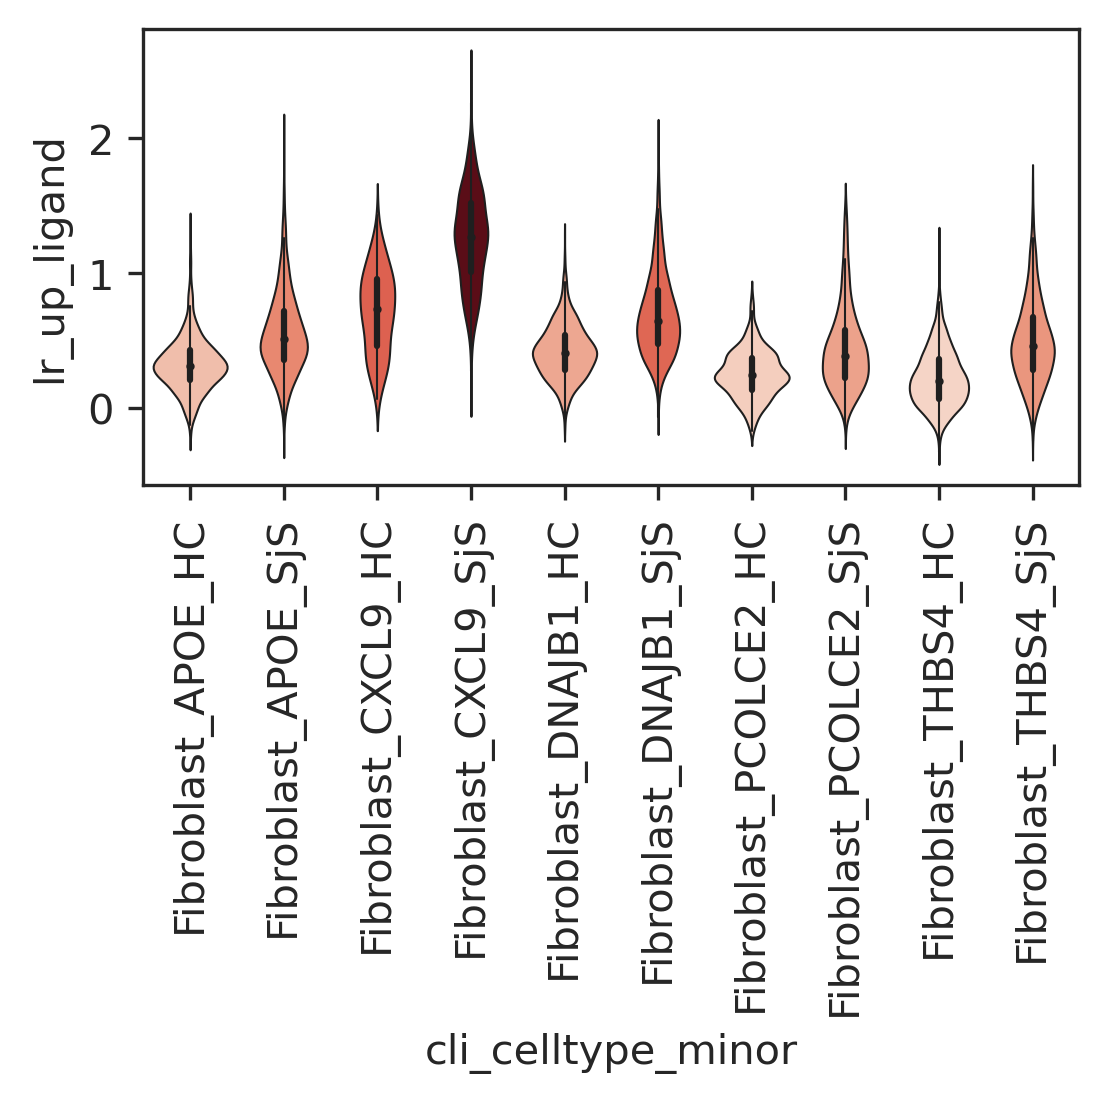

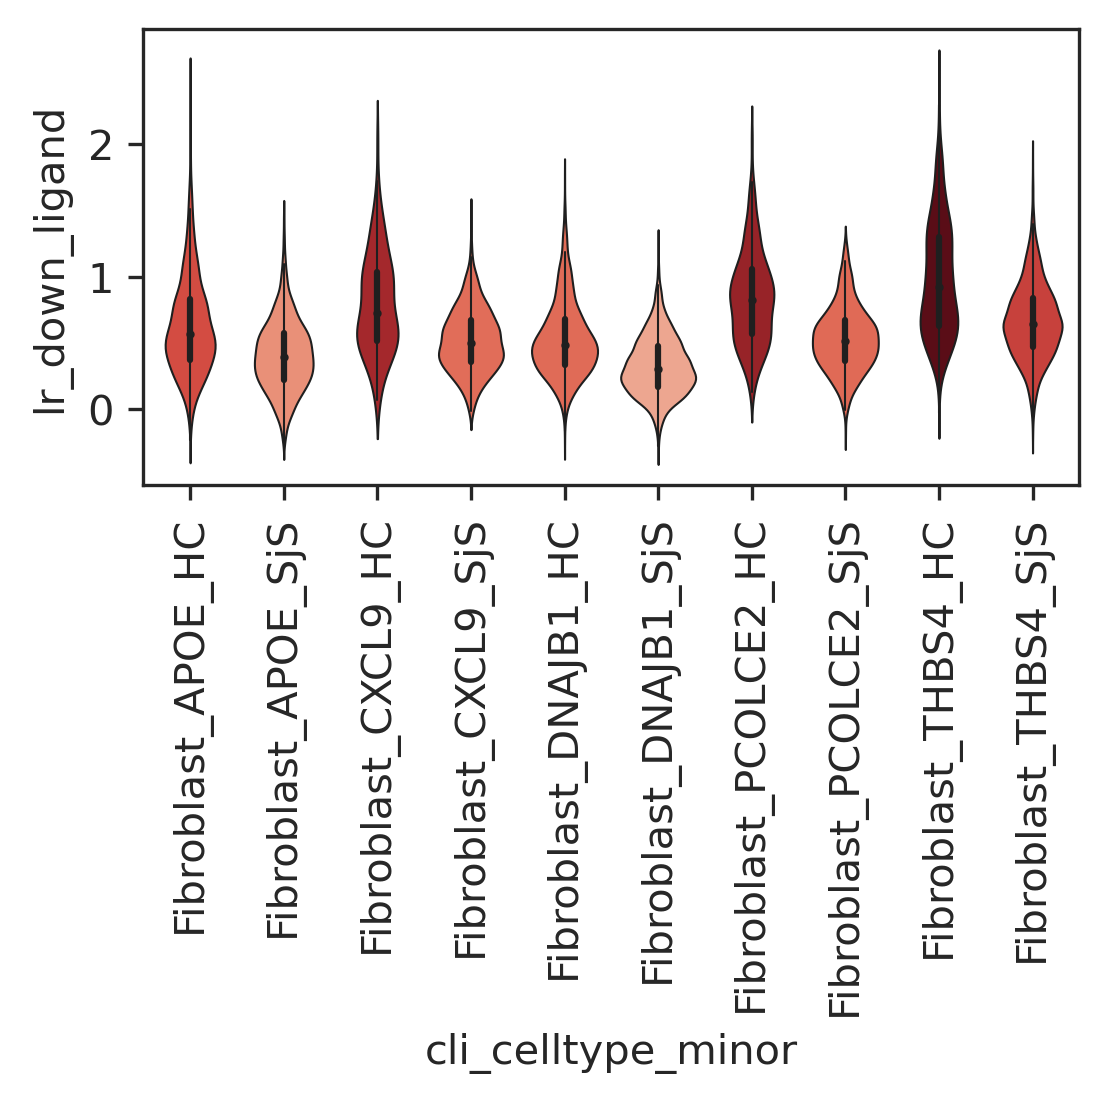

In [46]:
plt.subplots(figsize=(4,2))
colors = [cmap(c) for c in data.groupby('cli_celltype_minor').mean()['lr_up_ligand']/data.groupby('cli_celltype_minor').mean()['lr_up_ligand'].max()]
sns.violinplot(data=data,x='cli_celltype_minor',y='lr_up_ligand',linewidth=.5,order=np.unique(cx_fibro.obs['cli_celltype_minor']),palette=colors)
plt.xticks(rotation=90)
plt.savefig('cx_fibro_results/violin_cx_fibro_lr_up_genes_score.pdf')
plt.show()
plt.subplots(figsize=(4,2))
colors = [cmap(c) for c in data.groupby('cli_celltype_minor').mean()['lr_down_ligand']/data.groupby('cli_celltype_minor').mean()['lr_down_ligand'].max()]
sns.violinplot(data=data,x='cli_celltype_minor',y='lr_down_ligand',linewidth=.5,order=np.unique(cx_fibro.obs['cli_celltype_minor']),palette=colors)
plt.xticks(rotation=90)
plt.savefig('cx_fibro_results/violin_cx_fibro_lr_down_genes_score.pdf')
plt.show()

In [16]:
cx_fibro.obs['cli_celltype_minor'] = [cx_fibro.obs.loc[i,'celltype_minor'] +'_'+ cx_fibro.obs.loc[i,'cli_state'] for i in cx_fibro.obs['cli_state'].index]

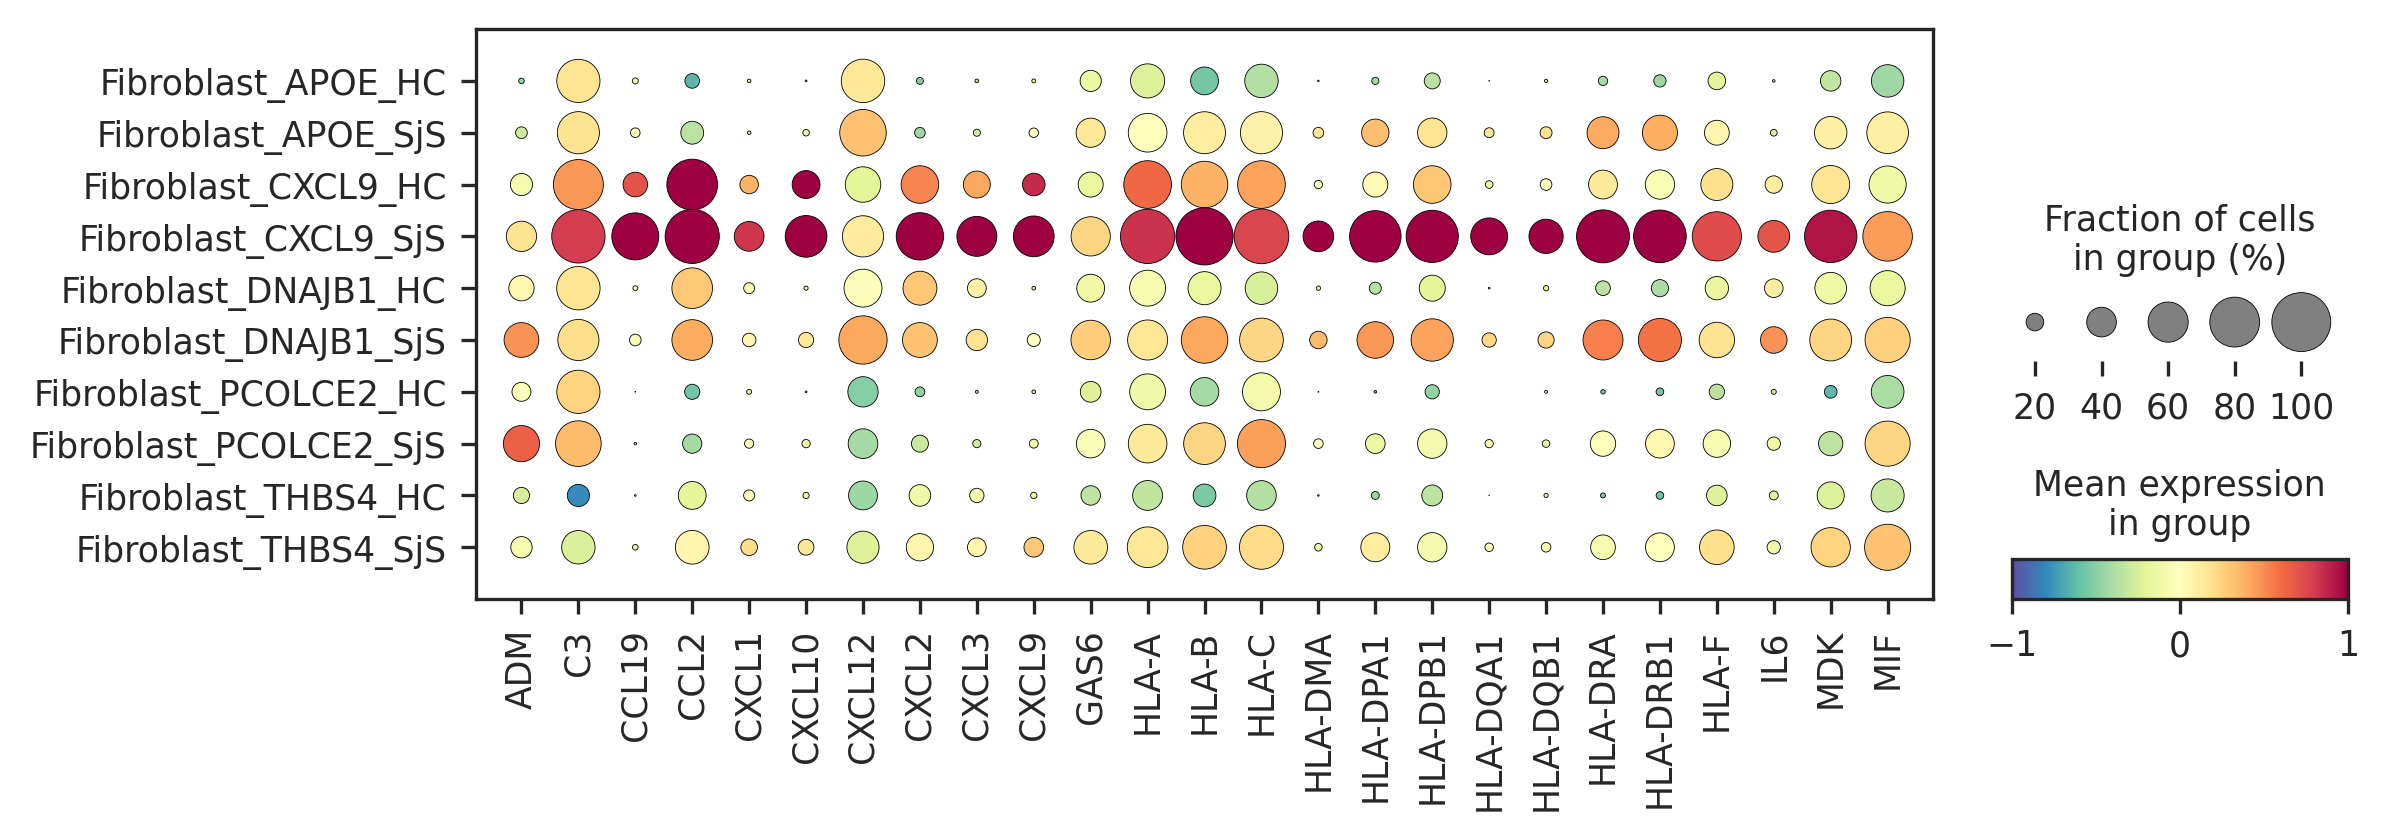

In [65]:
sc.pl.dotplot(cx_fibro,up_genes,groupby='cli_celltype_minor',use_raw=False,layer='scaled',cmap='Spectral_r',vmax=1,vmin=-1,figsize=(8,2.5),save='_cx_fibro_lr_ligand_up.pdf')

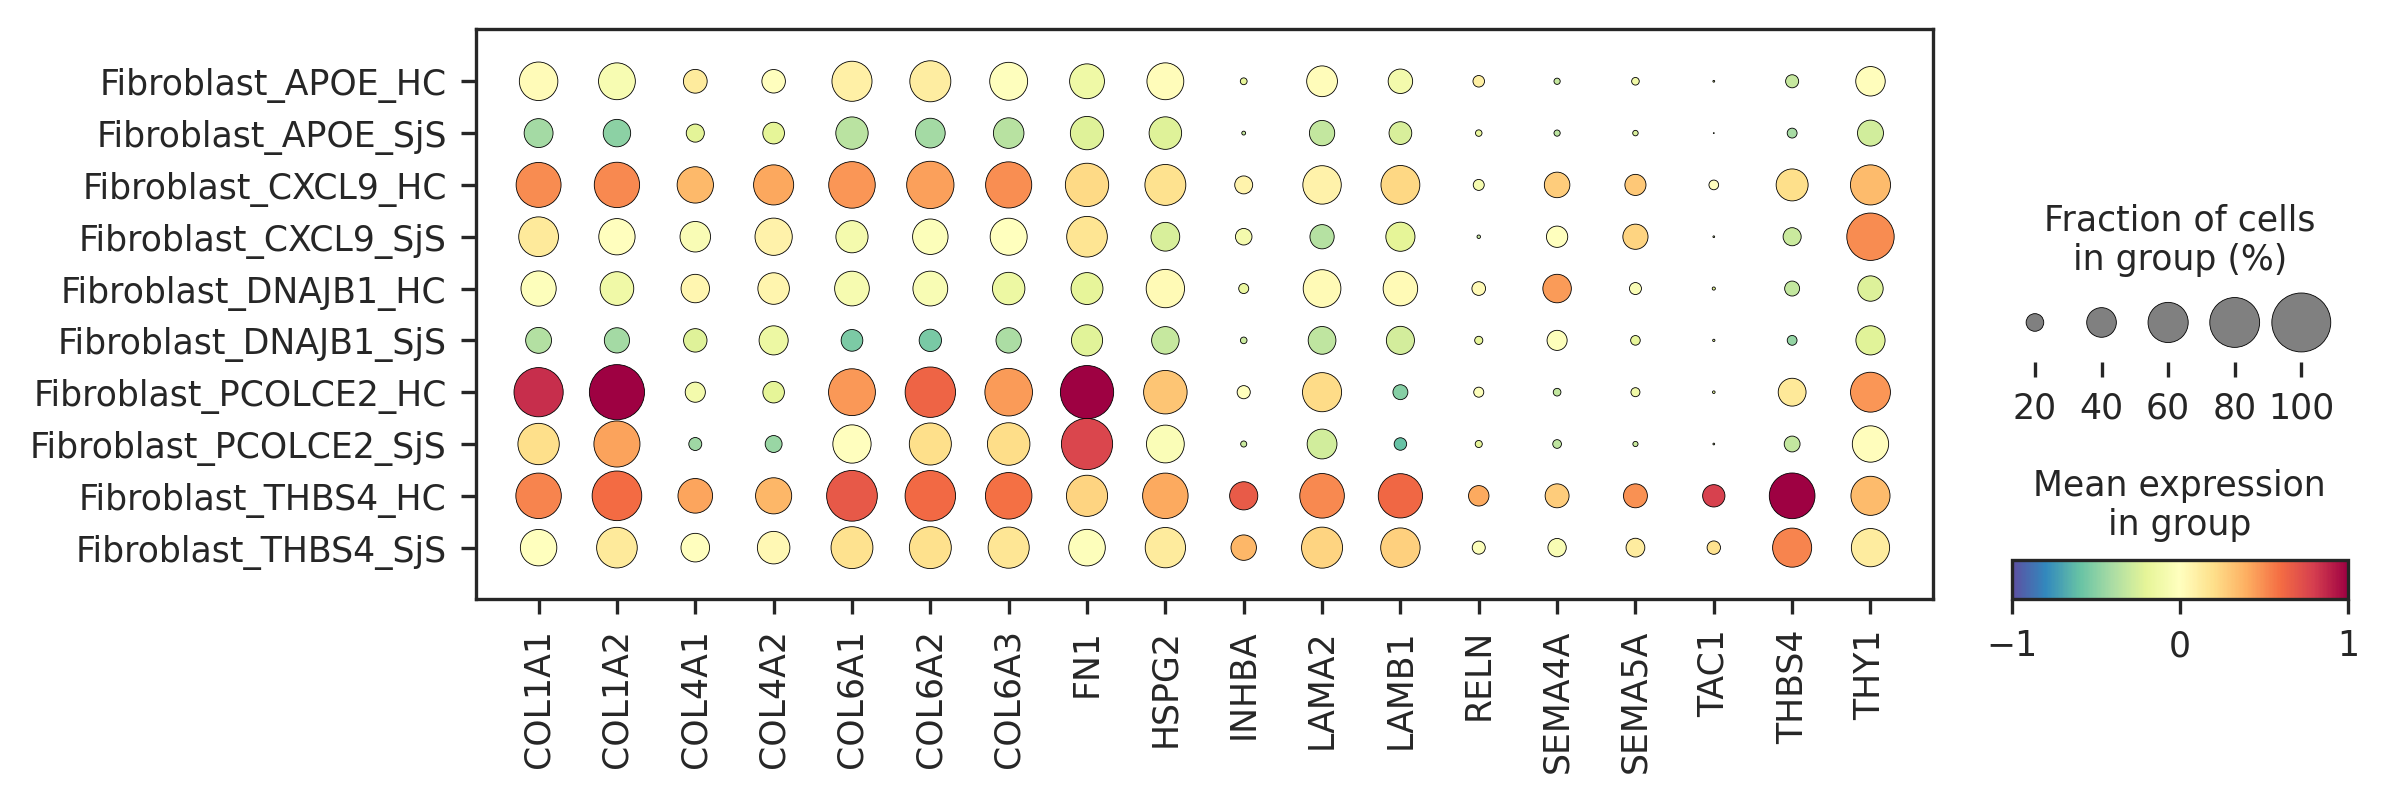

In [66]:
sc.pl.dotplot(cx_fibro,down_genes,groupby='cli_celltype_minor',use_raw=False,cmap='Spectral_r',layer='scaled',vmax=1,vmin=-1,figsize=(8,2.5),save='_cx_fibro_lr_ligand_down.pdf')

In [17]:
inflam_res = pd.read_csv('../scripts/CX_20211030/cx_fibro_results/GO_inflammatory_response.txt',index_col=0,sep='\t',header=None)
inflam_res_genes = inflam_res[1]
sc.tl.score_genes(cx_fibro,inflam_res_genes,score_name='inflam_res_score',use_raw=False)

computing score 'inflam_res_score'
    finished: added
    'inflam_res_score', score of gene set (adata.obs).
    933 total control genes are used. (0:00:00)


In [18]:
ecm_res = pd.read_csv('../scripts/CX_20211030/cx_fibro_results/NABA_CORE_MATRISOME.v2022.1.Hs.tsv',index_col=0,sep='\t',header=None)
ecm_genes = ecm_res.loc['MAPPED_SYMBOLS',1].split(',')
sc.tl.score_genes(cx_fibro,ecm_genes,score_name='ecm_score',use_raw=False)

computing score 'ecm_score'
    finished: added
    'ecm_score', score of gene set (adata.obs).
    944 total control genes are used. (0:00:00)


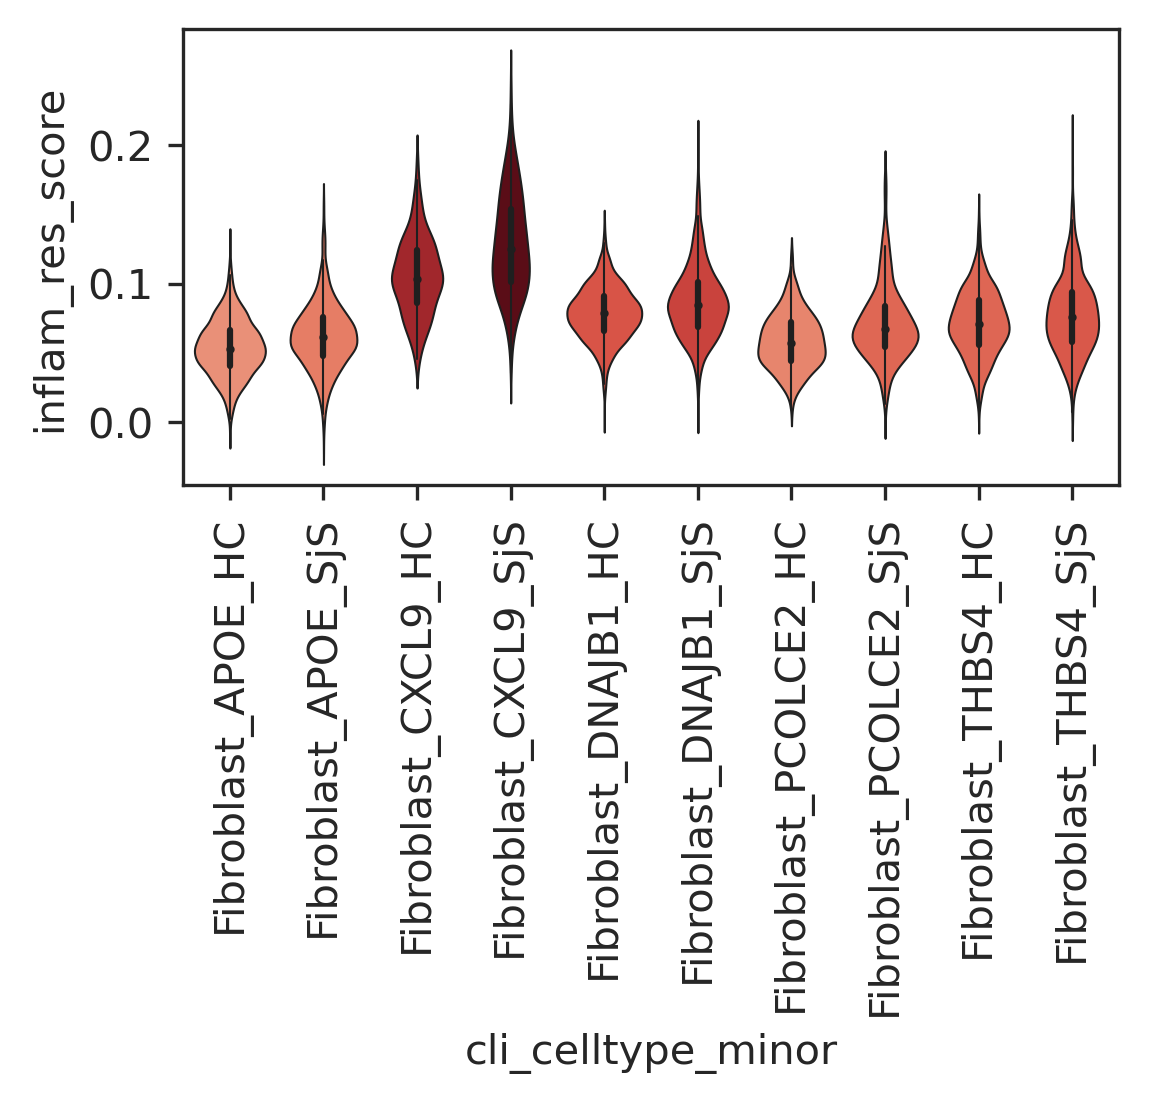

In [46]:
sns.set_style('ticks')
data = cx_fibro.obs[['cli_celltype_minor','inflam_res_score']]
plt.subplots(figsize=(4,2))
cmap=plt.get_cmap('Reds')
colors = [cmap(c) for c in data.groupby('cli_celltype_minor').mean()['inflam_res_score']/data.groupby('cli_celltype_minor').mean()['inflam_res_score'].max()]
sns.violinplot(data=data,x='cli_celltype_minor',y='inflam_res_score',linewidth=.5,order=np.unique(cx_fibro.obs['cli_celltype_minor']),palette=colors,fliersize=0)
plt.xticks(rotation=90)
plt.savefig('cx_fibro_results/violin_cx_fibro_inflam_res_score.pdf')
plt.show()

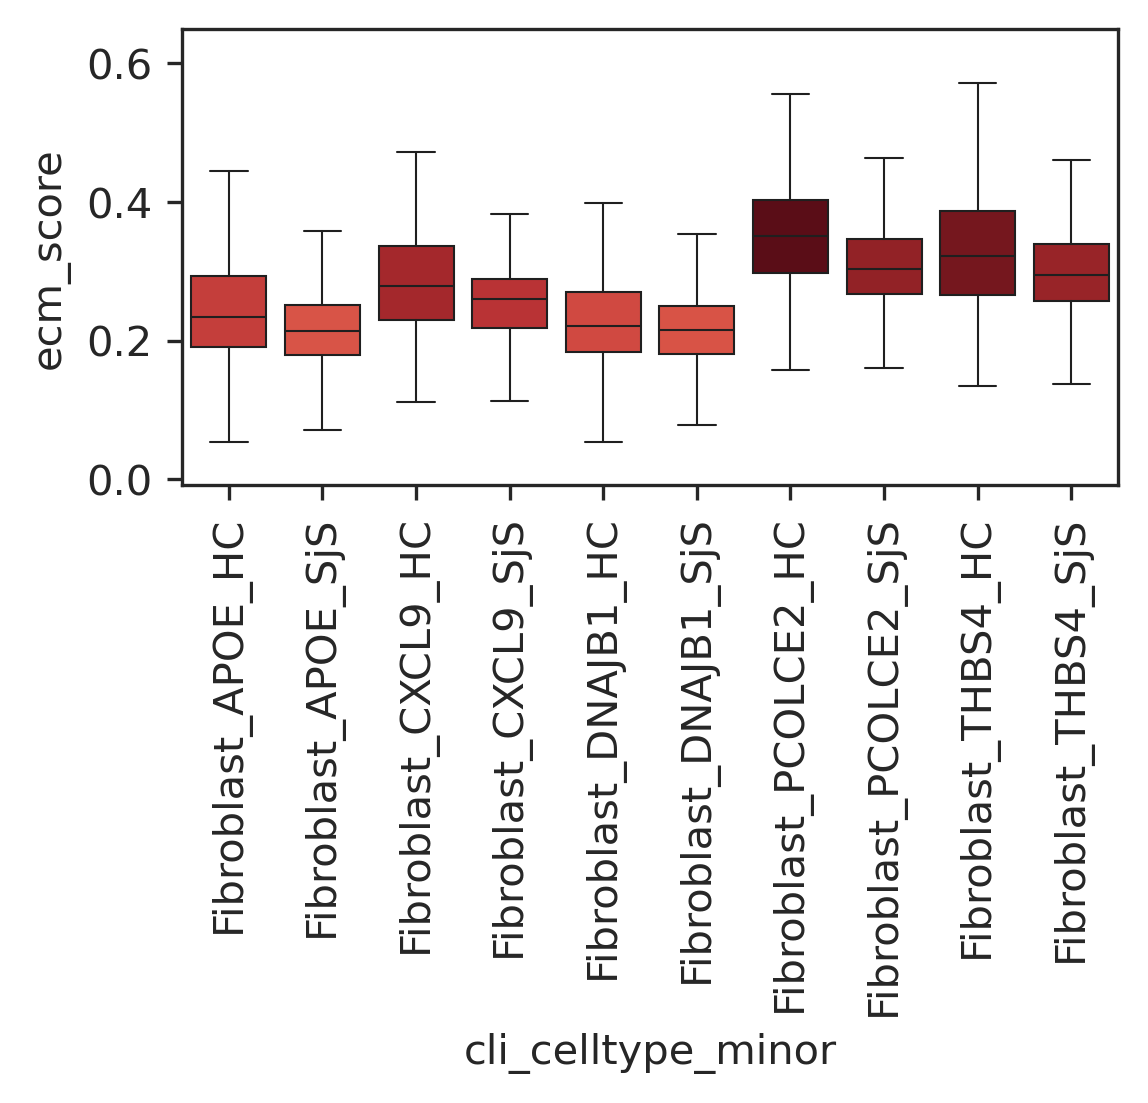

In [47]:
sns.set_style('ticks')
data = cx_fibro.obs[['cli_celltype_minor','ecm_score']]
plt.subplots(figsize=(4,2))
cmap=plt.get_cmap('Reds')
colors = [cmap(c) for c in data.groupby('cli_celltype_minor').mean()['ecm_score']/data.groupby('cli_celltype_minor').mean()['ecm_score'].max()]
sns.boxplot(data=data,x='cli_celltype_minor',y='ecm_score',linewidth=.5,order=np.unique(cx_fibro.obs['cli_celltype_minor']),palette=colors,fliersize=0)
plt.xticks(rotation=90)
plt.savefig('cx_fibro_results/boxplot_cx_fibro_ecm_score.pdf',bbox_inches='tight')
plt.show()

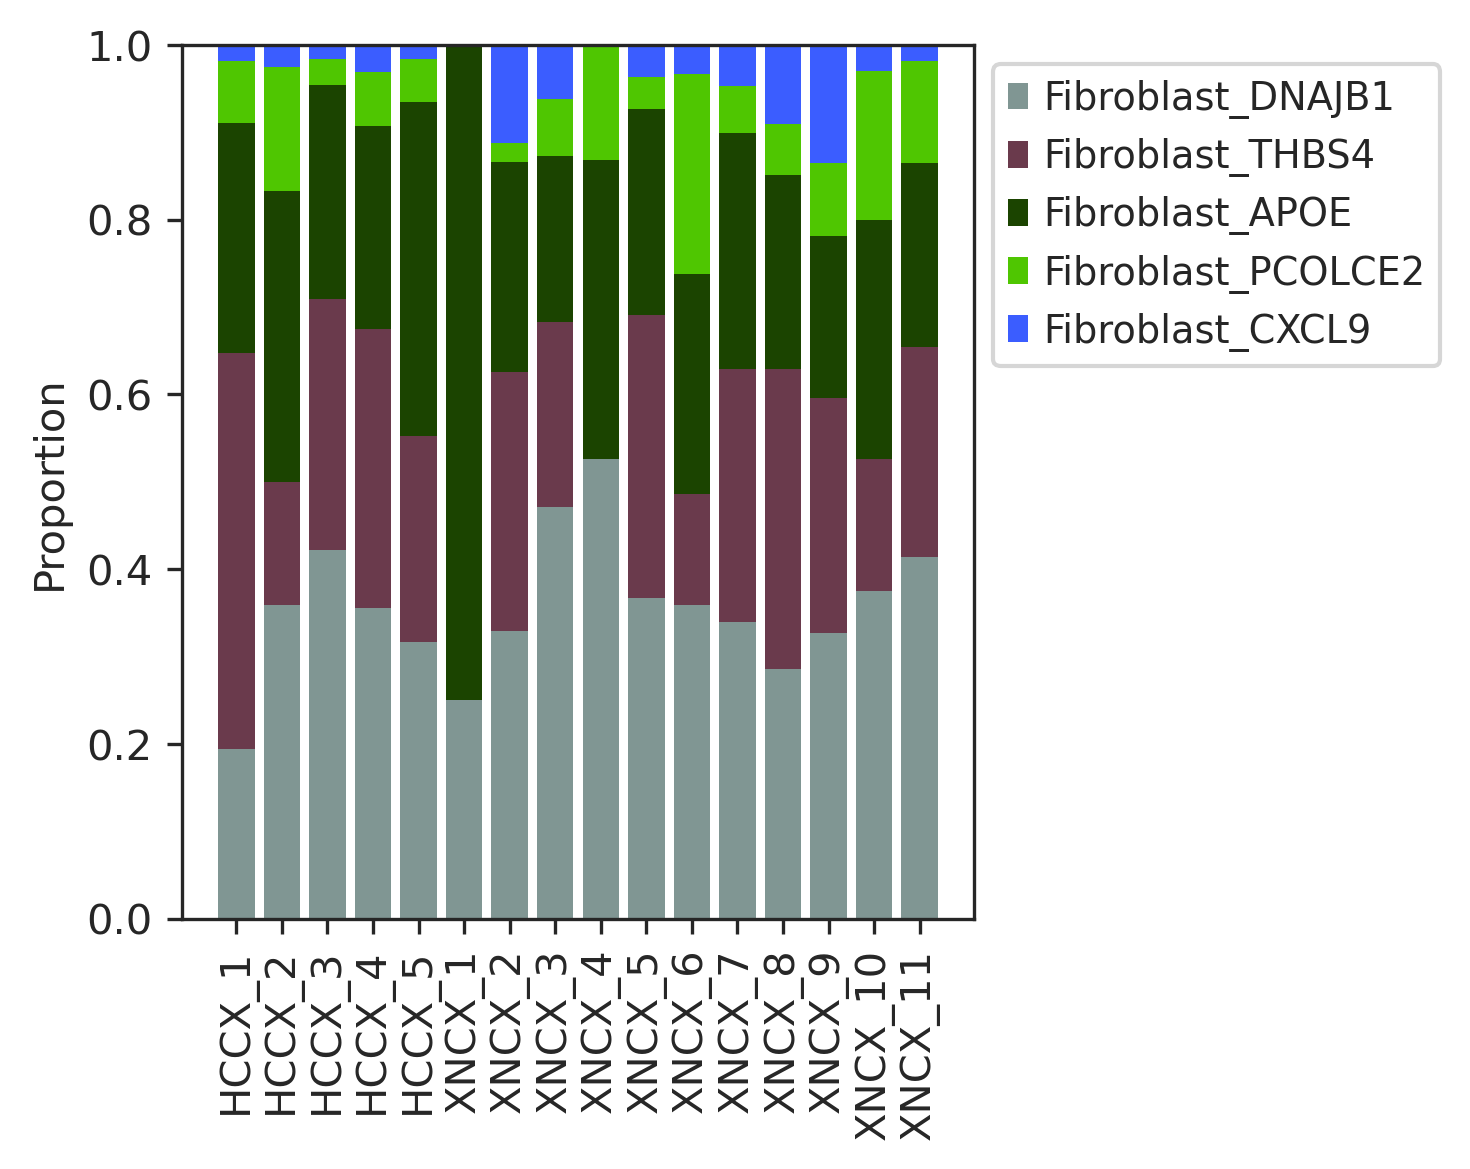

In [30]:
minor_p_df = plot_proportion(cx_fibro.obs,obs_x='sample',obs_y='celltype_minor',obs_x_order=cx_fibro.obs['sample'].cat.categories,obs_y_order=cx_fibro.obs['celltype_minor'].cat.categories,colors=cx_fibro.uns['celltype_minor_colors'],figsize=(5,4),save='cx_fibro_results/cx_fibro_celltype_minor_sample_proportion.pdf')


In [31]:
minor_p_df

,HCCX_1,HCCX_2,HCCX_3,HCCX_4,HCCX_5,XNCX_1,XNCX_2,XNCX_3,XNCX_4,XNCX_5,XNCX_6,XNCX_7,XNCX_8,XNCX_9,XNCX_10,XNCX_11
Fibroblast_DNAJB1,0.194587,0.358974,0.421502,0.355625,0.317073,0.25,0.328924,0.471358,0.526316,0.366492,0.359395,0.339048,0.285552,0.327460,0.375000,0.413855
Fibroblast_THBS4,0.453103,0.141026,0.287827,0.319375,0.235772,0.00,0.296296,0.211129,0.000000,0.324607,0.126103,0.289524,0.343572,0.268722,0.151316,0.240361
Fibroblast_APOE,0.263182,0.333333,0.245165,0.232500,0.382114,0.75,0.240741,0.189853,0.342105,0.235602,0.252207,0.270476,0.221843,0.185022,0.273026,0.210843
Fibroblast_PCOLCE2,0.070462,0.141026,0.029579,0.061250,0.048780,0.00,0.022046,0.065466,0.131579,0.036649,0.229508,0.053333,0.058020,0.083700,0.171053,0.116265
Fibroblast_CXCL9,0.018665,0.025641,0.015927,0.031250,0.016260,0.00,0.111993,0.062193,0.000000,0.036649,0.032787,0.047619,0.091013,0.135095,0.029605,0.018675


In [74]:
major_p_df.loc['Fibroblast',:]

HCCX_1     0.276766
HCCX_2     0.024598
HCCX_3     0.382923
HCCX_4     0.326998
HCCX_5     0.036629
XNCX_1     0.001124
XNCX_2     0.219300
XNCX_3     0.165807
XNCX_4     0.012799
XNCX_5     0.029067
XNCX_6     0.247195
XNCX_7     0.144429
XNCX_8     0.188829
XNCX_9     0.128418
XNCX_10    0.058160
XNCX_11    0.324536
Name: Fibroblast, dtype: float64

In [79]:
minor_total_p_df = minor_p_df*major_p_df.loc['Fibroblast',:]

In [32]:
minor_p_df_count = pd.DataFrame()

count = 0
for i in minor_p_df.index:
    for c in minor_p_df.columns:
        minor_p_df_count.loc[count,['celltype_minor','sample','proportion']] = [i,c,minor_p_df.loc[i,c]]
        count += 1

minor_p_df_count.loc[minor_p_df_count['sample'].isin(['HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5']),'cli_state'] = 'HC'
minor_p_df_count.loc[minor_p_df_count['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11']),'cli_state'] = 'SjS'

In [81]:
minor_total_p_df_count = pd.DataFrame()

count = 0
for i in minor_total_p_df.index:
    for c in minor_total_p_df.columns:
        minor_total_p_df_count.loc[count,['celltype_minor','sample','proportion']] = [i,c,minor_total_p_df.loc[i,c]]
        count += 1

minor_total_p_df_count.loc[minor_total_p_df_count['sample'].isin(['HCCX_1','HCCX_2','HCCX_3','HCCX_4','HCCX_5']),'cli_state'] = 'HC'
minor_total_p_df_count.loc[minor_total_p_df_count['sample'].isin(['XNCX_1','XNCX_2','XNCX_3','XNCX_4','XNCX_5','XNCX_6','XNCX_7','XNCX_8','XNCX_9','XNCX_10','XNCX_11']),'cli_state'] = 'SjS'

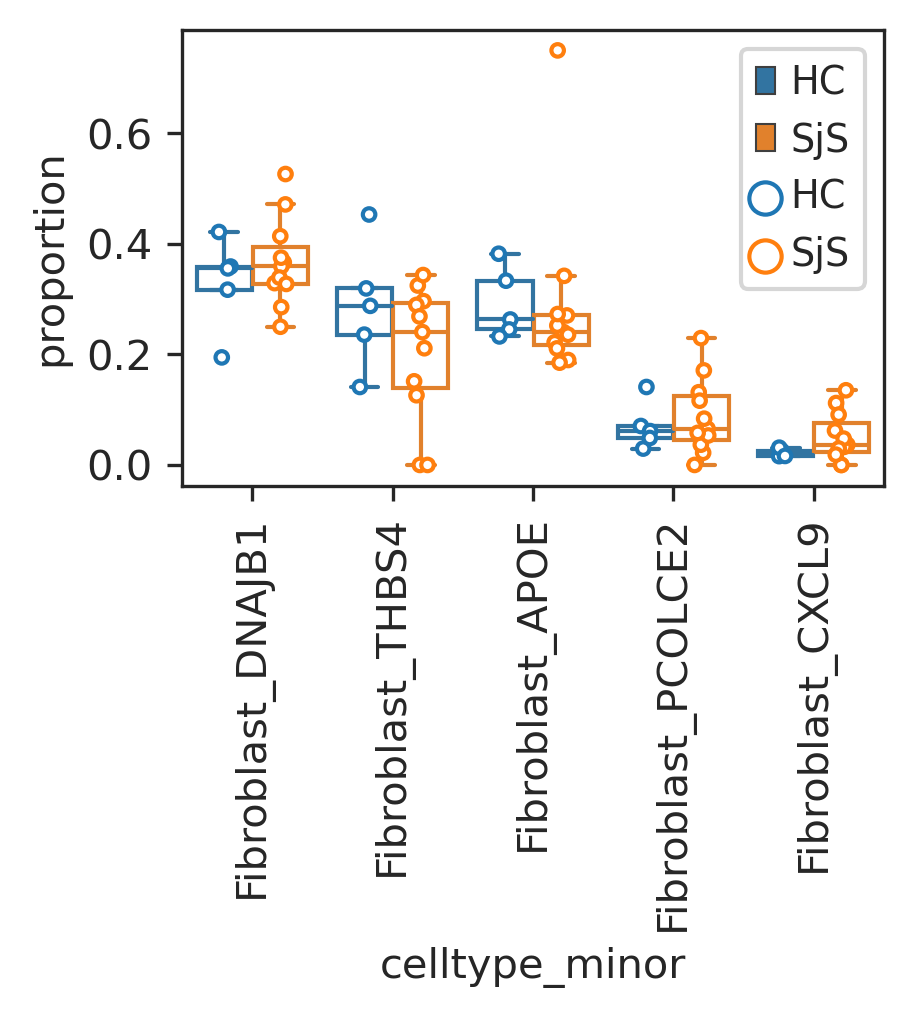

In [33]:
fig,ax=plt.subplots(figsize=(3,2))
sns.boxplot(data=minor_p_df_count,y='proportion',x='celltype_minor',hue='cli_state',ax=ax,fliersize=0,linewidth=1)
sns.stripplot(data=minor_p_df_count,y='proportion',x='celltype_minor',hue='cli_state',ax=ax,dodge=True,size=3,linewidth=1)
plt.xticks(rotation=90)
# box lines
for i, box in enumerate(ax.artists):
    color = box.get_facecolor()
    box.set_edgecolor(color)
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i, 6*(i+1)):
        ax.lines[j].set_color(color)

# scatter points
for coll in ax.collections:
    color = coll.get_facecolor()
    coll.set_edgecolor(color)
    coll.set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('cx_fibro_results/boxplot_cx_fibro_celltype_minor_proportion.pdf',bbox_inches='tight')
plt.show()